### SENTIMENT ANALYSIS ON IGBO DATA

### Objective

- Build a model that can classify sentiments on news articles as positive, neutral or negative.

### Data

The data was gotten from the NaijaSenti's manually annotated Igbo tweets found <a href = "https://github.com/hausanlp/NaijaSenti/tree/main"> here </a>.

In [115]:
# uncomment the code below to install wordcloud
#!pip install wordcloud
#!pip install emoji

In [225]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import string
import emoji
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud #ensure wordcloud is installed
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import nltk

%matplotlib inline

In [211]:
# load data
data1 = pd.read_csv("data/train.tsv", delimiter='\t')
data2 = pd.read_csv("data/dev.tsv", delimiter='\t')

data = pd.concat([data1, data2])
data.sample(5)

,tweet,label
300,🥺🥺🥺 chineke mgbe olee? https://t.co/HsJUA5jzwG,negative
3832,@user aligo i mana onona mmiri asaaru bukwa or...,neutral
1322,Nnem gbáwá àgbawa gá cheeki onwé gí ofụma befo...,negative
1618,☀️#WeekendRide w. @user 🎶Obodo Bu Igwe || @use...,negative
844,Ya na nsogbu ya na ele cartoon https://t.co/Kq...,negative


### Data Wrangling and Preprocessing

In [157]:
data.shape

(12033, 2)

In [159]:
# check distribution of sentiments
data["label"].value_counts()

label
neutral     5319
positive    3644
negative    3070
Name: count, dtype: int64

In [161]:
# checking for missing values
data.isnull().sum()

tweet    0
label    0
dtype: int64

In [317]:
def clean(data,column):
  
  # save the pattern for the punctuation and special characters in regex
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))

  # Replace emojis with text
  #data['clean_tweet'] = data['clean_tweet'].apply(lambda x: emoji.demojize(x, delimiters=(' ', ' '), language='en'))

  # replace the punctuation with nothing for each word in the list
  # and join the words back into a string
  data[column] = data[column].apply(lambda x: ' '.join([re_punc.sub('', word) for word in x.split()]))

  # remove extra special characters not handled above
  data[column] = data[column].apply(lambda x: ' '.join([re.sub(r'[’,-, @]','', word) for word in x.split()]))

  # remove links
  data[column] = data[column].apply(lambda x: ' '.join([re.sub(r'http\S+|www.\S+', '', word) for word in x.split()]))

  # remove html tags
  data[column] = data[column].apply(lambda x: ' '.join([re.sub(r"<.*?>", '', word) for word in x.split()])) 
    
  # remove extra whitspace
  data[column] = data[column].apply(lambda x: x.strip())

  # lower case
  data[column] = data[column].apply(lambda x: x.lower())
    
  print("Data successfully cleaned!")


  return data[column]

In [281]:
data['clean_tweet'] = clean(data, 'tweet')
data['clean_tweet'].sample(10)

Data successfully cleaned!


9482                        user nwaanyi oma dalụ rinne 😊
7381                       user user áká ọrụ gị amaka 👌👍✔
602          user user chi gi ahu egbu kwa na gi dia 🙄😭😭😭
2247    user user user ha aputawago 🌚 ndị junkie ndị j...
1724             user user 🤣 🤣 🤣 ya ifele emero gi na ọnụ
6726    user doc hapu kwa m aka o nke onye nacho na uw...
1527     user user user user user user iburo ezigbo mmadụ
6233                         user user mgbe niile ohh😭🙏❤️
857     user nne hapu ogologo okwu ife e nacho nelu di...
7098    user user user in other words okwu naga zamzam...
Name: clean_tweet, dtype: object

In [283]:
from collections import defaultdict

# Initialize a defaultdict with integer values to store word frequencies
vocab = defaultdict(int)

corpus = data["clean_tweet"]

# Loop through each sentence in the corpus and count no. of occurrence of each word
for article in corpus.apply(lambda x: x.split()):
    for word in article:
        vocab[word] += 1

# Convert the defaultdict vocab to a regular dictionary for easier handling and sorting
# and sort the dictionary by word frequency in descending order
sorted_vocab = dict(sorted(vocab.items(), key=lambda x: x[1], reverse=True))

# Display the sorted vocabulary with each word and its frequency count
#print("Vocabulary with Frequencies:", sorted_vocab)

In [285]:
#  remove stopwords
IGBO_STOPWORDS = {
    "ihe",
    "na",
    "nke",
    "mana",
    "n’",
    "ka",
    "ma",
    "ya",
    "si",
    "ga",
    "di",
    "onye",
    "ndị",
    "bụ",
    "ọ",
    "a",
    "e",
    "i",
    "ị",
    "o",
    "ha",
    "unu",
    "anyị",
    "gị",
    "m",
    "mụ",
    "ọ bụla",
    "ọbụna",
    "gịnị",
    "ebee",
    "olee",
    "ole",
    "ahụ",
    "kedụ",
    "maka",
    "mụ onwe m",
    "onwe m",
    "gị onwe gị",
    "onwe gị",
    "ya onwe ya",
    "onwe ya",
    "anyị onwe anyị",
    "onwe anyị",
    "unu onwe unu",
    "onwe unu",
    "ha onwe ha",
    "onwe ha",
    "mụ wa",
    "gị wa",
    "ya wa",
    "anyị wa",
    "unu wa",
    "ha wa",
    "mụ nwa",
    "gị nwa",
    "ya nwa",
    "anyị nwa",
    "unu nwa",
    "ha nwa",
    "na",
    "n’",
    "n'",
    "n\"",
    "n’ime",
    "nime",
    "niime",
    "n’elu",
    "nelu",
    "neelu",
    "n’ihi",
    "niihi",
    "nihi",
    "naka",
    "naaka",
    "n’aka",
    "nakụkụ",
    "naakụkụ",
    "n’akụkụ",
    "n’okpuru",
    "nokpuru",
    "noookpuru",
    "n’ebe",
    "nebe",
    "nebee",
    "n’ebee",
    "n’anya",
    "nanya",
    "n’ụzọ",
    "nụzọ",
    "na nkọnkọ",
    "n’azụ",
    "nazụ",
    "ganye ma",
    "ganye na",
    "ya mere",
    "gbasara",
    "site",
    "mgbe",
    "n’ezie",
    "nezie",
    "kama",
    "ka ọ bụ",
    "kaọbụ",
    "ka ọ bụrụ",
    "kaọbụrụ",
    "ma ọ bụ",
    "maọbụ",
    "ma ọ bụrụ",
    "maọbụrụ",
    "kamgbe",
    "kemgbe",
    "nwere ike",
    "mee",
    "gunyere",
    "banyere"
    "niile",
    "nile",
    "ọtụtụ",
    "ụfọdụ",
    "ka o si na dị",
    "ka o si dị",
    "ka ọ na dị",
    "maka - because",
    "kwa",
    "mana",
    "maọbụ",
    "tupu",
    "tutuu",
    "dị",
    "dịka",
    "dịghị",
    "ghị",
    "beghi",
    "bụghị",
    "gaghị",
    "ee",
    "mba",
    "ihe",
    "ruo",
    "rute"}

print(len(IGBO_STOPWORDS))

134


In [287]:
for word, freq in sorted_vocab.items():
  if freq >= 600 and word not in IGBO_STOPWORDS:
    IGBO_STOPWORDS.add(word)
IGBO_STOPWORDS = IGBO_STOPWORDS.union(ENGLISH_STOP_WORDS)
print(len(IGBO_STOPWORDS))

458


In [289]:
def remove_stopwords(text, stopwords):
    words = text.split()  # tokenize by whitespace
    filtered_words = [word for word in words if word not in stopwords]
    return " ".join(filtered_words)

# Apply the function to each article in the DataFrame
data["clean_tweet"] = data["clean_tweet"].apply(lambda row: remove_stopwords(row, IGBO_STOPWORDS))

data["clean_tweet"].sample(10)

9120     ndewo isonyere w oge obinwanne huru chi boo cc...
10027                                    hahaha nyere egwu
927                                     nogolu like 5 days
7457                        ibu ezigbo mmadu ngwanu better
9662     mgp gidi gidi ugwu ezechọọ ewu ojii chi dịokuk...
6882     mpa chimdi nweru ìhè ona adị ná achọ ná ani 😂😂😀😀🏃
644                anam aga ebeahu ugbua egbughi oge obula
9374                ututu oma nolunke oma weekend aa nunwa
857      🤣🤣 nye nkegiohapuzialum kam nwee ilotaba otu n...
7924                                    gaadi oru ebube ☺️
Name: clean_tweet, dtype: object

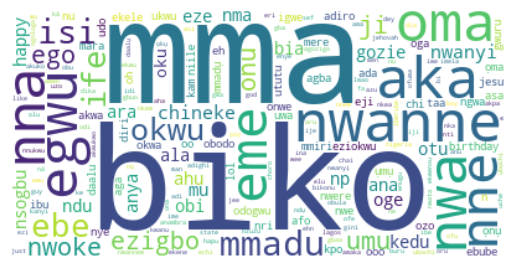

In [239]:
# create word cloud for the review body
words = " ".join([t for t in data['clean_tweet']])
word_cloud = WordCloud(stopwords = IGBO_STOPWORDS, collocations = False, background_color = 'white').generate(words)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [241]:
# fraction of reviews
data.label.value_counts()/len(data)

label
neutral     0.442034
positive    0.302834
negative    0.255132
Name: count, dtype: float64

In [295]:
# Replace emojis with text
data['clean_tweet'] = data['clean_tweet'].apply(lambda x: emoji.demojize(x, delimiters=(' ', ' '), language='en'))
data['clean_tweet'].sample(10)

2955    kee odi nti puru eme obodo ah naija red_heart ...
1199                                  oga mechipu onu dia
3864                                      abia ibem shall
329     “ndi alaa” dey ghost mode  smiling_face_with_s...
8611                     isee daalụ nwoke ọma dikwara mma
1576                           nsogbu ke ife ịmụ anya eme
3585                  asa gbalu mmadu boot phyno eme nini
7256    eze chinco  face_with_tears_of_joy  face_with_...
3334               nwe eji  smiling_face_with_sunglasses 
5378                           ebe tegokwa mua natara ụlọ
Name: clean_tweet, dtype: object

In [297]:
# define the vectorizer and specify the arguments, ngrams (1,3) considers unigram - one word, bigram - two consecutive words, trigram - three words 
vect = TfidfVectorizer(ngram_range=(1, 3), max_features=500, token_pattern=r'\b[^\d\W][^\d\W]+\b', stop_words=list(IGBO_STOPWORDS)).fit(data['clean_tweet'])

# Transform the vectorizer
num_txt = vect.transform(data['clean_tweet']).toarray()
 

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aka', 'akụkụ', 'anya', 'azụ', 'bụla', 'bụrụ', 'ebe', 'elu', 'ezie', 'ganye', 'ihi', 'ime', 'mere', 'nkọnkọ', 'nwa', 'nwere', 'okpuru', 'onwe', 'wa', 'ụzọ'] not in stop_words.
  warnings.warn(


In [299]:
# define target and features
y = data.label
X = num_txt

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [301]:
# Build model and calculate the accuracy

def build(model):
    model = model().fit(X_train, y_train)

    return model

def result(model):
    
    # predicting and calculating accuracy
    predict = model.predict(X_test)
    # classification report
    print(classification_report(y_test,predict))

    # plot confusion matrix
    cm = confusion_matrix(y_test,predict)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

In [303]:
model = build(LogisticRegression)

              precision    recall  f1-score   support

    negative       0.66      0.57      0.61       612
     neutral       0.66      0.79      0.72      1051
    positive       0.84      0.71      0.77       744

    accuracy                           0.71      2407
   macro avg       0.72      0.69      0.70      2407
weighted avg       0.72      0.71      0.71      2407



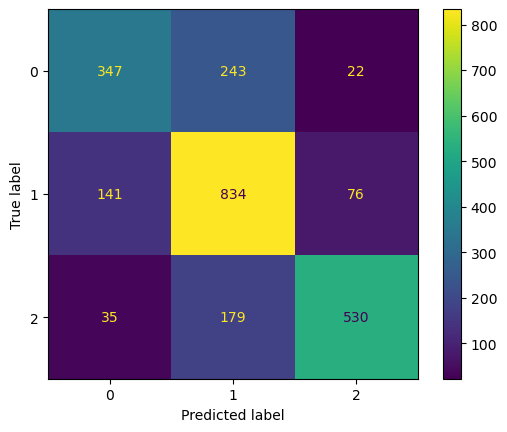

In [305]:
result(model)

In [307]:
# RandomForestClassifier model
model = build(RandomForestClassifier)

              precision    recall  f1-score   support

    negative       0.64      0.56      0.60       612
     neutral       0.68      0.76      0.72      1051
    positive       0.78      0.74      0.76       744

    accuracy                           0.70      2407
   macro avg       0.70      0.69      0.69      2407
weighted avg       0.70      0.70      0.70      2407



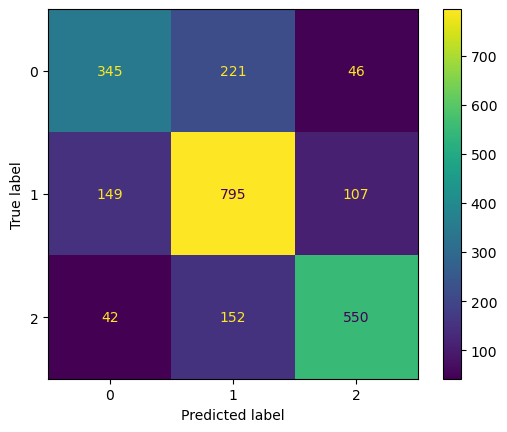

In [308]:
result(model)

In [309]:
# GaussianNB model
model = build(GaussianNB)

              precision    recall  f1-score   support

    negative       0.39      0.89      0.54       612
     neutral       0.70      0.31      0.43      1051
    positive       0.84      0.61      0.71       744

    accuracy                           0.55      2407
   macro avg       0.65      0.60      0.56      2407
weighted avg       0.67      0.55      0.54      2407



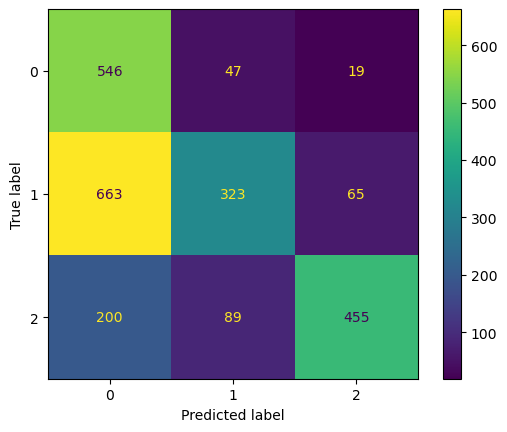

In [313]:
result(model)

              precision    recall  f1-score   support

    negative       0.57      0.56      0.57       612
     neutral       0.65      0.67      0.66      1051
    positive       0.72      0.70      0.71       744

    accuracy                           0.65      2407
   macro avg       0.65      0.64      0.65      2407
weighted avg       0.65      0.65      0.65      2407



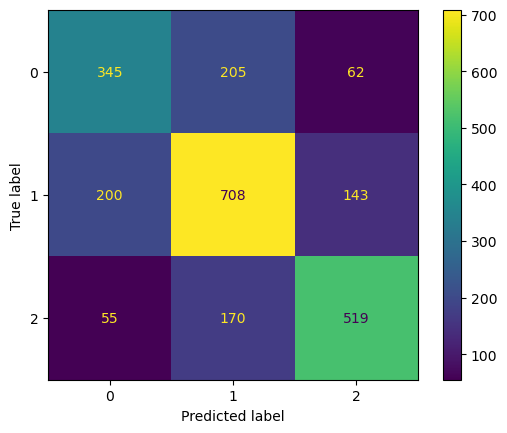

In [315]:
#build DecisionTreeClassifier model
model = build(DecisionTreeClassifier)
result(model)